Exclude the records that SATIVA has highligted, redo the alignment and rebuild the tree.

In [4]:
from reprophylo import *

In [2]:
pj=Project('../fetch_clean_align_tree/reptile_target_locus.csv', pickle='rep_post_SATIVA.pkl', git=False)

DEBUG:Cloud:Log file (/root/.picloud/cloud.log) opened


In [3]:
pj.read_embl_genbank(['../fetch_clean_align_tree/12S_preSATIVA_reptiles.gb'])

/home/reprophylo/reprophylo.py:1015: UserWarning: Version control off
  warnings.warn('Version control off')


In [4]:
pj.extract_by_locus()

Set the stage:

In [5]:
recs_to_keep = {'rrnS': []}
recs_to_drop = {'rrnS': []}

print "to drop: %s" %len(recs_to_drop['rrnS'])
print "to keep: %s" %len(recs_to_keep['rrnS'])

print "TOTAL: %s" %(len(recs_to_drop['rrnS']) + len(recs_to_keep['rrnS']))

to drop: 0
to keep: 0
TOTAL: 0


Record all record ids and assign them the status keep.

In [6]:
for r in pj.records_by_locus['rrnS']:
    recs_to_keep['rrnS'].append("_".join(r.id.split("_")[:-1]))

In [7]:
print "to drop: %s" %len(recs_to_drop['rrnS'])
print "to keep: %s" %len(recs_to_keep['rrnS'])

print "TOTAL: %s" %(len(recs_to_drop['rrnS']) + len(recs_to_keep['rrnS']))

to drop: 0
to keep: 113
TOTAL: 113


How many do we want to drop? Parse SATIVA output and extract records ids putatively mislabeled.

In [8]:
rec_mislabelled = {}
sativa=open('../SATIVA/12S.mis', 'r')

for line in sativa:
    if not line.startswith(";"):
        rec_mislabelled[line.split("\t")[0]] = line.split("\t")[4]
        

In [9]:
print len(rec_mislabelled)

1


Adjust lists accordingly.

In [10]:
for r in rec_mislabelled:
    print r
    if not r in recs_to_drop['rrnS']:
        print "\tadd to droplist"
        recs_to_drop['rrnS'].append(r)
    for i in reversed(range(len(recs_to_keep['rrnS']))):
#        print i
        if r in recs_to_keep['rrnS'][i]:
            print "\tremove from keeplist"
            del(recs_to_keep['rrnS'][i])

HQ442366.1
	add to droplist
	remove from keeplist


In [11]:
print "to drop: %s" %len(recs_to_drop['rrnS'])
print "to keep: %s" %len(recs_to_keep['rrnS'])

print "TOTAL: %s" %(len(recs_to_drop['rrnS']) + len(recs_to_keep['rrnS']))

to drop: 1
to keep: 112
TOTAL: 113


Write out good records in full Genbank format including all metadata. Adjust to valid species and taxids before doing it.

Identify records with Subspecies.

In [12]:
from collections import defaultdict

Seqs = []
taxon_to_taxid = {}
recs_to_adjust = defaultdict(list)
taxon_to_recs = defaultdict(list)

for r in pj.records:
    if r.id in recs_to_keep['rrnS']:
        Seqs.append(r)
        
        source = [f for f in r.features if f.type == 'source'][0]

        #screen for subspecies and record taxids of valid species
        #if valid species record the taxid
        if (len(source.qualifiers['organism'][0].split(" ")) == 2):
            print source.qualifiers['organism'][0],
            if 'db_xref' in source.qualifiers:
#                print source.qualifiers['db_xref']
                for t in source.qualifiers['db_xref']:
#                    print t
                    if 'taxon' in t:
                        if not source.qualifiers['organism'][0] in taxon_to_taxid:
                            print " .. add to records"
                            taxon_to_taxid[source.qualifiers['organism'][0]] = t.split(":")[1]
                        else:
                            print " .. already covered"
                        taxon_to_recs[source.qualifiers['organism'][0]].append(r.id)
        #if the species status is 'sp.' but has a valid taxid
        elif (len(source.qualifiers['organism'][0].split(" ")) > 2 and source.qualifiers['organism'][0].split(" ")[1] == 'sp.'):
            print source.qualifiers['organism'][0],
            if 'db_xref' in source.qualifiers:
                for t in source.qualifiers['db_xref']:
                    if 'taxon' in t:
                        if not source.qualifiers['organism'][0] in taxon_to_taxid:
                            print " .. add to records"
                            taxon_to_taxid[source.qualifiers['organism'][0]] = t.split(":")[1]
                        else:
                            print " .. already covered" 
                        taxon_to_recs[source.qualifiers['organism'][0]].append(r.id)
        #all other cases we consider dubious, e.g. supspecies
        else:
            print "subspecies: %s" %source.qualifiers['organism'][0]
            recs_to_adjust[r.id] = []

Podarcis muralis  .. add to records
Podarcis muralis  .. already covered
Emys orbicularis  .. add to records
Podarcis muralis  .. already covered
Chelonia mydas  .. add to records
Zootoca vivipara  .. add to records
Zootoca vivipara  .. already covered
Zootoca vivipara  .. already covered
Eretmochelys imbricata  .. add to records
Zootoca vivipara  .. already covered
Eretmochelys imbricata  .. already covered
Chelonia mydas  .. already covered
Lacerta viridis  .. add to records
Emys orbicularis  .. already covered
Lacerta agilis  .. add to records
Eretmochelys imbricata  .. already covered
Podarcis muralis  .. already covered
Chelydra serpentina  .. add to records
Trachemys scripta  .. add to records
Podarcis muralis  .. already covered
Chelonia mydas  .. already covered
Podarcis muralis  .. already covered
Podarcis muralis  .. already covered
Podarcis muralis  .. already covered
Podarcis muralis  .. already covered
Lacerta viridis  .. already covered
Lepidochelys kempii  .. add to reco

Check if any of the taxa that were considered dubious are not already covered in the list after removing subspecies.

In [13]:
from collections import defaultdict

to_fetch = defaultdict(list)

for r in Seqs:
    if r.id in recs_to_adjust:
        source = [f for f in r.features if f.type == 'source'][0]
        adjust_from = source.qualifiers['organism'][0]
        adjust_to = " ".join(adjust_from.split(" ")[:2])
        print "%s -> %s" %(adjust_from,adjust_to)
        if adjust_to in taxon_to_taxid:
            taxon_to_recs[adjust_to].append(r.id)
            recs_to_adjust[r.id].append(adjust_to)
            recs_to_adjust[r.id].append(taxon_to_taxid[adjust_to])
        else:
            to_fetch[adjust_to].append(r.id)
            recs_to_adjust[r.id].append(adjust_to)

Chrysemys picta bellii -> Chrysemys picta
Emys orbicularis orbicularis -> Emys orbicularis
Trachemys scripta scripta -> Trachemys scripta
Emys orbicularis orbicularis -> Emys orbicularis
Lacerta viridis viridis -> Lacerta viridis
Trachemys scripta elegans -> Trachemys scripta
Trachemys scripta elegans -> Trachemys scripta
Mus musculus castaneus -> Mus musculus
Mus musculus musculus -> Mus musculus
Mus musculus castaneus -> Mus musculus
Mus musculus castaneus -> Mus musculus
Mus musculus castaneus -> Mus musculus
Mus musculus musculus -> Mus musculus
Mus musculus molossinus -> Mus musculus
Mus musculus musculus -> Mus musculus
Mus musculus domesticus -> Mus musculus
Mus musculus musculus -> Mus musculus
Xenopus laevis sudanensis -> Xenopus laevis
Mus musculus musculus -> Mus musculus
Mus musculus castaneus -> Mus musculus


In [14]:
print recs_to_adjust

defaultdict(<type 'list'>, {'HQ681908.1': ['Emys orbicularis', '82168'], 'DQ874614.2': ['Mus musculus', '10090'], 'HQ681907.1': ['Emys orbicularis', '82168'], 'KF781660.1': ['Mus musculus', '10090'], 'KF781662.1': ['Mus musculus', '10090'], 'AY057791.1': ['Mus musculus', '10090'], 'KF781663.1': ['Mus musculus', '10090'], 'AY581640.1': ['Xenopus laevis', '8355'], 'AM176577.1': ['Lacerta viridis', '65476'], 'KF781656.1': ['Mus musculus', '10090'], 'JX945964.1': ['Mus musculus', '10090'], 'KF781653.1': ['Mus musculus', '10090'], 'KF874616.1': ['Chrysemys picta', '8479'], 'KF781661.1': ['Mus musculus', '10090'], 'AY057793.1': ['Mus musculus', '10090'], 'GU477770.1': ['Trachemys scripta', '34903'], 'KM216749.1': ['Trachemys scripta', '34903'], 'AY057792.1': ['Mus musculus', '10090'], 'KF781654.1': ['Mus musculus', '10090'], 'KM216748.1': ['Trachemys scripta', '34903']})


In [15]:
print len(to_fetch)

0


In [16]:
#print to_fetch

In [17]:
#from Bio import Entrez
#Entrez.email = "L.Harper@2015.hull.ac.uk"

#for binomial in to_fetch:
    #print binomial
    #handle = Entrez.esearch(db="Taxonomy", term=binomial)
    #record = Entrez.read(handle)
    #print record["IdList"][0]
    #taxon_to_taxid[binomial] = record["IdList"][0]
    
    #taxon_to_recs[binomial] = to_fetch[binomial]

Update the dictionary that contains binomial, taxid for every record id with the ones that we have just fetched from NCBI.

In [18]:
#for sp in to_fetch:
#    print to_fetch[sp]
#    for r in to_fetch[sp]:
#        print r,recs_to_adjust[r]
#        recs_to_adjust[r].append(taxon_to_taxid[recs_to_adjust[r][0]])
#        print r,recs_to_adjust[r]

Modify the records (if necessary) - adjust subspecies to species.

In [19]:
for r in Seqs:
    if r.id in recs_to_adjust:
        print "adjusting %s" %r.id
        source = r.features[0]
        print "%s\t->\t%s" %(source.qualifiers['organism'][0],recs_to_adjust[r.id][0])
        source = r.features[0]
        source.qualifiers['organism'] = [recs_to_adjust[r.id][0]]
#        print source.qualifiers['organism']
        for i in range(len(source.qualifiers['db_xref'])):
            if 'taxon' in source.qualifiers['db_xref'][i]:
                source.qualifiers['db_xref'][i] = "taxon:"+recs_to_adjust[r.id][1]
        if not 'note' in source.qualifiers:
            source.qualifiers['note'] = ['modified from original record: adjusted to species']
        else:
            source.qualifiers['note'].append('modified from original record: adjusted to species')
#        print r.format('genbank')       
#    print r,recs_to_adjust[r]

adjusting KF874616.1
Chrysemys picta bellii	->	Chrysemys picta
adjusting HQ681907.1
Emys orbicularis orbicularis	->	Emys orbicularis
adjusting KM216749.1
Trachemys scripta scripta	->	Trachemys scripta
adjusting HQ681908.1
Emys orbicularis orbicularis	->	Emys orbicularis
adjusting AM176577.1
Lacerta viridis viridis	->	Lacerta viridis
adjusting GU477770.1
Trachemys scripta elegans	->	Trachemys scripta
adjusting KM216748.1
Trachemys scripta elegans	->	Trachemys scripta
adjusting KF781663.1
Mus musculus castaneus	->	Mus musculus
adjusting KF781656.1
Mus musculus musculus	->	Mus musculus
adjusting KF781660.1
Mus musculus castaneus	->	Mus musculus
adjusting AY057792.1
Mus musculus castaneus	->	Mus musculus
adjusting KF781661.1
Mus musculus castaneus	->	Mus musculus
adjusting KF781654.1
Mus musculus musculus	->	Mus musculus
adjusting AY057793.1
Mus musculus molossinus	->	Mus musculus
adjusting AY057791.1
Mus musculus musculus	->	Mus musculus
adjusting JX945964.1
Mus musculus domesticus	->	Mus

Write only good records with all metadata in Genbank format.

In [20]:
from Bio import SeqIO
       
out = open('../12S_UKreptiles_SATIVA_cleaned.gb','w')
SeqIO.write(Seqs, out, "genbank")
out.close()

Exclude the records that were highlighted by SATIVA. Then realign and rebuild phylogeny.

In [21]:
pj.exclude(start_from_max=False, **recs_to_drop)

In [22]:
species=[]
for r in pj.records:
    if r.id in recs_to_keep['rrnS']:
        source = [f for f in r.features if f.type == 'source'][0]
        species.append(" ".join(source.qualifiers['organism'][0].split()[0:2]))
    
#print set(species)
total=len(species)
species=list(set(species))

print "Total number of records: %i" %total
print "Number of species (see below for full list): %i" %len(species)
print sorted(species)

Total number of records: 112
Number of species (see below for full list): 22
['Anguis fragilis', 'Caretta caretta', 'Chelonia mydas', 'Chelydra serpentina', 'Chrysemys picta', 'Coronella austriaca', 'Cottus gobio', 'Dermochelys coriacea', 'Emys orbicularis', 'Eretmochelys imbricata', 'Lacerta agilis', 'Lacerta viridis', 'Lepidochelys kempii', 'Mauremys caspica', 'Mus musculus', 'Natrix natrix', 'Podarcis muralis', 'Trachemys scripta', 'Vipera berus', 'Xenopus laevis', 'Zamenis longissimus', 'Zootoca vivipara']


Write short 12S rRNA sequences (< 400bp) to fasta file to build new alignment outside Reprophylo later in script using hmmbuild. The Hidden Markov Model alignment will include all 12S rRNA sequences - short and long.

In [23]:
temp_seq = []

for r in pj.records_by_locus['rrnS']:
    if len(r.seq) < 400:
        temp_seq.append(r)
        
total = len(temp_seq)
print "Total number of records: %i" %total

from Bio import SeqIO

out=open('reptile_short_to_align_SATIVA.fasta','w')
SeqIO.write(temp_seq, out, 'fasta')
out.close()

Total number of records: 33


# Filter by Length

Write cropped records (minimum length of 400bp) to fasta and Genbank file.

In [24]:
from Bio import SeqIO

temp=[]
for r in pj.records:
    if len(r.seq) >= 400:
        temp.append(r)

out = open('reptile12S_cropped_400bp_SATIVA.gb', 'w')
SeqIO.write(temp, out, 'genbank')
out.close()

out = open('reptile12S_cropped_400bp_SATIVA.fa', 'w')
SeqIO.write(temp, out, 'fasta')
out.close()


del(temp)

Now view records in cropped genbank file.

In [25]:
for index, record in enumerate(SeqIO.parse("reptile12S_cropped_400bp_SATIVA.gb", "genbank")):
        print("index %i, ID = %s, length %i, with %i features"
          % (index, record.id, len(record.seq), len(record.features)))

index 0, ID = AJ001471.1, length 544, with 2 features
index 1, ID = JX454972.1, length 969, with 2 features
index 2, ID = GQ142072.1, length 459, with 2 features
index 3, ID = KM401599.1, length 953, with 2 features
index 4, ID = KF781329.1, length 430, with 2 features
index 5, ID = JX454980.1, length 968, with 2 features
index 6, ID = JX454970.1, length 968, with 2 features
index 7, ID = JX454976.1, length 969, with 2 features
index 8, ID = AJ001480.1, length 543, with 2 features
index 9, ID = AF149947.1, length 460, with 2 features
index 10, ID = KP221806.1, length 969, with 2 features
index 11, ID = L28077.1, length 966, with 2 features
index 12, ID = JX454990.1, length 969, with 2 features
index 13, ID = AJ001472.1, length 547, with 2 features
index 14, ID = AJ001470.1, length 544, with 2 features
index 15, ID = AF149962.1, length 465, with 2 features
index 16, ID = AY770536.1, length 440, with 2 features
index 17, ID = JX454983.1, length 970, with 2 features
index 18, ID = AF14996

Now need to filter all 12S rRNA sequences within pj.records dictionary by length to remove all sequences shorter than 400bp within Reprophylo.

Distribution Of Sequence Lengths
Distribution Of Sequence Statistic "Gc_Content"


/usr/lib/pymodules/python2.7/matplotlib/figure.py:371: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


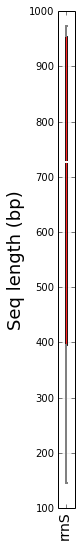

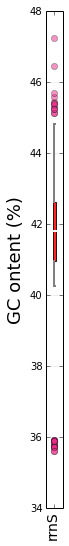

In [26]:
%matplotlib inline
pj.report_seq_stats()

In [27]:
# Define minima and maxima

gc_inliers = {
    'rrnS': [40,46]
}
len_inliers = {
    'rrnS': [400,1000]
}


# Apply to loci data
for locus in gc_inliers:
    # trim GC outliers
    pj.filter_by_gc_content(locus,
                            min_percent_gc=gc_inliers[locus][0],
                            max_percent_gc=gc_inliers[locus][1])

    # trim length outlier
    pj.filter_by_seq_length(locus,
                            min_length=len_inliers[locus][0],
                            max_length=len_inliers[locus][1])

Confirm that the length filter has worked.

Distribution Of Sequence Lengths
Distribution Of Sequence Statistic "Gc_Content"


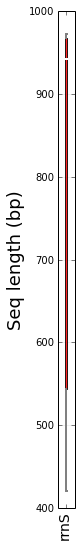

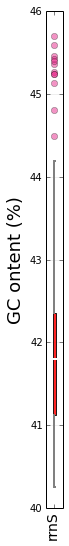

In [28]:
pj.report_seq_stats()

Pickle the project.

In [29]:
pickle_pj(pj, 'rep_post_SATIVA.pkl')

'rep_post_SATIVA.pkl'

# Long Alignment

Now, need to produce a sequence alignment file based on an alignment of all 12S sequences longer than 400bp. This will be done with the AlnConf class.

In [30]:
pj = unpickle_pj('rep_post_SATIVA.pkl', git=False)

muscle default configuration:

In [31]:
muscle_default = AlnConf(pj,
                         method_name="muscleDefault-400bp-SATIVA",
                         program_name="muscle",
                         loci=['rrnS'])

muscle -in 815371477497805.69_rrnS.fasta


In [32]:
pj.align([muscle_default])

In [33]:
print pj.used_methods['muscleDefault-400bp-SATIVA']

AlnConf named muscleDefault-400bp-SATIVA with ID 815371477497805.69
Loci: rrnS 
Created on: Wed Oct 26 16:03:25 2016
Commands:
rrnS: muscle -in 815371477497805.69_rrnS.fasta

Environment:
Platform: Linux-4.4.0-38-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: biopc4
 Program and version: MUSCLE v3.8.31\nPal2Nal v14
 Program reference:\nEdgar 2004: MUSCLE: multiple sequence alignment with high accuracy and high throughput. Nucleic Acids Research 32(5):1792-1797\nMikita Suyama
 David Torrents
 and Peer Bork (2006) PAL2NAL: robust conversion of protein sequence alignments into the corresponding codon alignments.Nucleic Acids Res. 34
 W609-W612.
execution time:
8.54806089401


Core Methods section sentence:
The dataset(s) rrnS w

In [34]:
pj.alignments

{'rrnS@muscleDefault-400bp-SATIVA': <<class 'Bio.Align.MultipleSeqAlignment'> instance (62 records of length 1043, IUPACProtein()) at 7f7bd5d29f50>}

In [35]:
# record_id and source_organism are feature qualifiers in the SeqRecord object
files = pj.write_alns(id=['record_id','source_organism'],
                      format='fasta')
files

['rrnS@muscleDefault-400bp-SATIVA_aln.fasta']

Pickle the project.

In [36]:
pickle_pj(pj, 'rep_post_SATIVA.pkl')

'rep_post_SATIVA.pkl'

# Build tree from long alignment

Trim the alignment.

In [37]:
muscle_gappyout = TrimalConf(pj,                       # The Project

                            method_name='gappyout',  # Any unique string 
                                                     # ('gappyout' is default)
                            
                            program_name='trimal',   # No alternatives in 
                                                     # this ReproPhylo version
                            
                            cmd='default',           # the default is trimal. 
                                                     # Change it here
                                                     # or in pj.defaults['trimal']
                            
                            alns=['rrnS@muscleDefault-400bp-SATIVA'],  # 'all' by default
                            
                            trimal_commands={'gappyout': True} # By default, the gappyout algorithm is used.
                           )

trimal -in 339891477497877.55_rrnS@muscleDefault-400bp-SATIVA.fasta -gappyout


In [38]:
pj.trim([muscle_gappyout])

In [39]:
print pj.used_methods['gappyout']

TrimalConf named gappyout with ID 339891477497877.55
Alignments: rrnS@muscleDefault-400bp-SATIVA 
Created on: Wed Oct 26 16:04:37 2016
Commands:
rrnS@muscleDefault-400bp-SATIVA@gappyout: trimal -in 339891477497877.55_rrnS@muscleDefault-400bp-SATIVA.fasta -gappyout

Environment:Platform: Linux-4.4.0-38-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: biopc4
 Program and version: trimAl 1.2rev59
 Program reference: Salvador Capella-Gutierrez; Jose M. Silla-Martinez; Toni Gabaldon. trimAl: a tool for automated alignment trimming in large-scale phylogenetic analyses. Bioinformatics 2009 25: 1972-1973.
execution time:
0.460474967957

Core Methods section sentence:
The alignment(s) rrnS@muscleDefault-400bp-SATIVA were trimmed using 

In [40]:
pj.trimmed_alignments

{'rrnS@muscleDefault-400bp-SATIVA@gappyout': <<class 'Bio.Align.MultipleSeqAlignment'> instance (62 records of length 757, IUPACAmbiguousDNA()) at 7f7bd5a99410>}

In [41]:
files = pj.write_trimmed_alns(id=['record_id','source_organism'],
                                   format='fasta')
files

['rrnS@muscleDefault-400bp-SATIVA@gappyout_trimmed_aln.fasta']

Infer Maximum Likelihood tree based on the clipped alignment. We are going to use RAxML. Configure RAxML for trimmed muscle alignment.

In [42]:
raxml = RaxmlConf(pj, method_name='raxml-muscleDefault-400bp-SATIVA-trimmed',
                  program_name='raxmlHPC-PTHREADS-SSE3',
                  keepfiles=True,
                  cmd='raxmlHPC-PTHREADS-SSE3',
                  preset='fa',
                  alns=['rrnS@muscleDefault-400bp-SATIVA@gappyout'],
                  model='GAMMA',
                  threads=5,
                  cline_args={'-#': 100})

raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 387341477497898.72_rrnS@muscleDefault-400bp-SATIVA@gappyout0 -p 206 -s 387341477497898.72_rrnS@muscleDefault-400bp-SATIVA@gappyout.fasta -T 5 -x 328 -N 100


Infer tree.

In [43]:
pj.tree([raxml])

In [44]:
print pj.used_methods['raxml-muscleDefault-400bp-SATIVA-trimmed']

RaxmlConf named raxml-muscleDefault-400bp-SATIVA-trimmed with ID 387341477497898.72
Alignments: rrnS@muscleDefault-400bp-SATIVA@gappyout 
Created on: Wed Oct 26 16:04:58 2016
Commands:
rrnS@muscleDefault-400bp-SATIVA@gappyout:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 387341477497898.72_rrnS@muscleDefault-400bp-SATIVA@gappyout0 -p 206 -s 387341477497898.72_rrnS@muscleDefault-400bp-SATIVA@gappyout.fasta -T 5 -x 328 -N 100

Environment:
Platform: Linux-4.4.0-38-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: biopc4
 Program and version: raxmlHPC-PTHREADS-SSE3RAxML version 8.0.12
 Program reference: A. Stamatakis: RAxML Version 8: A tool for Phylogenetic Analysis and Post-Analysis of Large Phylogenies. In Bioinformatics
 2014.


In [45]:
pickle_pj(pj, 'rep_post_SATIVA.pkl')

'rep_post_SATIVA.pkl'

# Visualise Tree

Annotate final tree.

In [46]:
pj.add_qualifier_from_source('organism')

In [47]:
supports = {'black': [100,95],
            'dimgray': [95,75],
            'silver': [75,50]}

In [48]:
for species in ['Cottus','Mus','Xenopus']:
    pj.if_this_then_that(species, 'organism', 'outgroup', 'outgroup',
                         mode='part')

In [49]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=None,
            html='muscleDefault-trimmed-400bp-reptile-raxml-post_SATIVA.html')

Create a static copy of the tree (the last *.png with the expected alignment id) for later.

In [50]:
%%bash

last_png=$(ls -hlrt *rrnS@muscleDefault-400bp-SATIVA@gappyout.png | tail -n 1 | perl -ne 'chomp; @a=split(" "); print "$a[-1]"')
cp $last_png rrnS_muscleDefault_trimmed_reptile_400bp_SATIVA_raxml.png

Pickle the project.

In [51]:
pickle_pj(pj, 'rep_post_SATIVA.pkl')

'rep_post_SATIVA.pkl'

**=======================================================================================================**

In [52]:
from reprophylo import *

In [53]:
pj = unpickle_pj('rep_post_SATIVA.pkl', git=False)

- Identify the record IDs of the sequences shorter than 500bp
- Write these sequences to new fasta file (make sure the sequence IDs are as Reprophylo expects them: 'id_f0')
- Prepare a hmm profile for the alignment the tree is built on (either muscle 'or mafft)

In [54]:
pj.alignments

{'rrnS@muscleDefault-400bp-SATIVA': <<class 'Bio.Align.MultipleSeqAlignment'> instance (62 records of length 1043, IUPACProtein()) at 7f7bd26668d0>}

In [55]:
from Bio import AlignIO

out=open('400bp_reptile_align_SATIVA.fasta','w')

AlignIO.write(pj.fta('rrnS@muscleDefault-400bp-SATIVA'), out, 'fasta')

returning trimmed alignment object rrnS@muscleDefault-400bp-SATIVA@gappyout


1

Check number of records in file containing short 12S rRNA sequences.

In [56]:
from Bio import SeqIO

records = list(SeqIO.parse("reptile_short_to_align_SATIVA.fasta", "fasta"))
print("Total records: %i" % len(records))


Total records: 33


Check that record IDs are in format that reprophylo expects for alignment.

In [57]:
from Bio import SeqIO

short_seq = open("reptile_short_to_align_SATIVA.fasta", "rU")
sequences = []

for r in SeqIO.parse(short_seq, "fasta"):
    print(r.id)


AY151988.1_f0
KX080575.1_f0
HG802830.1_f0
AY151993.1_f0
HG802772.1_f0
DQ081074.1_f0
U81335.1_f0
KT030712.1_f0
EF027342.1_f0
AY151990.1_f0
FJ039991.1_f0
AB090021.1_f0
HG802786.1_f0
AY151992.1_f0
AF080277.1_f0
DQ081073.1_f0
AF080334.1_f0
HG802805.1_f0
U81329.1_f0
HQ681907.1_f0
AF080298.1_f0
KX694589.1_f0
HQ681908.1_f0
U81328.1_f0
U81340.1_f0
EU624267.1_f0
KT030713.1_f0
AB090043.1_f0
KX080601.1_f0
AF158461.1_f0
KX080576.1_f0
JQ287761.1_f0
M13046.1_f0


If record IDs were not in the format Reprophylo expects for tree construction, the code cells below could be used to format them to be 'id_f0'.

In [58]:
#temp_seq = []

#for r in pj.records:
    #if len(r.seq) < 500:
        #temp_seq.append(r)

#from Bio import SeqIO

#out=open('short_to_align.fasta','w')
#SeqIO.write(temp_seq, out, 'fasta')
#out.close()

In [59]:
#from Bio import SeqIO

#short_seq = open("short_to_align.fasta", "rU")
#sequences = []

#for r in SeqIO.parse(short_seq, "fasta"):
    #print(r.id)
    #r.description = r.id+'_f0'
    #r.id = r.description
    #print r.description
    #sequences.append(r)


#out = open("seq_to_align.fasta", "w")
#SeqIO.write(sequences, out, "fasta")
#out.close()

Check that sequences in reprophylo project have not been altered.

In [60]:
for r in pj.records:
    if len(r.seq) < 400:
        print r.id
        print r.description

AY151988.1
Podarcis muralis isolate E2106124 12S ribosomal RNA gene, partial sequence; mitochondrial gene for mitochondrial product.
KX080575.1
Podarcis muralis isolate 509 12S ribosomal RNA gene, partial sequence; mitochondrial.
HG802830.1
Emys orbicularis partial 12S rRNA gene, specimen voucher MTD:T:1488.
AY151993.1
Zootoca vivipara 12S ribosomal RNA gene, partial sequence; mitochondrial gene for mitochondrial product.
HG802772.1
Emys orbicularis partial 12S rRNA gene, specimen voucher MTD:T:3244.
DQ081074.1
Podarcis muralis isolate MTA1 12S ribosomal RNA gene, partial sequence; mitochondrial.
U81335.1
Chelydra serpentina 12S mitochondrial ribosomal RNA, small subunit, mitochondrial gene, partial sequence.
KT030712.1
Podarcis muralis isolate Mur01 12S ribosomal RNA gene, partial sequence; mitochondrial.
EF027342.1
Podarcis muralis isolate 1 12S ribosomal RNA gene, partial sequence; mitochondrial.
AY151990.1
Podarcis muralis isolate E2106126 12S ribosomal RNA gene, partial sequence; 

Pickle the project.

In [61]:
pickle_pj(pj, 'rep_post_SATIVA.pkl')

'rep_post_SATIVA.pkl'

# Add short sequences to reference alignment

In [1]:
!hmmbuild 12S_reptile_ref_SATIVA.hmm 400bp_reptile_align_SATIVA.fasta

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.1b1 (May 2013); http://hmmer.org/
# Copyright (C) 2013 Howard Hughes Medical Institute.
# Freely distributed under the GNU General Public License (GPLv3).
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             400bp_reptile_align_SATIVA.fasta
# output HMM file:                  12S_reptile_ref_SATIVA.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen     W eff_nseq re/pos description
#---- -------------------- ----- ----- ----- ----- -------- ------ -----------
1     400bp_reptile_align_SATIVA    62   757   757   934     2.52  0.450 

# CPU time: 0.29u 0.00s 00:00:00.28 Elapsed: 00:00:00.30


Now use hmmalign to align the short 12S rRNA sequences to the longer reference alignment.

In [2]:
%%bash

hmmalign -o 12S_reptile400bpref_plus_short_query_SATIVA.sto \
--mapali 400bp_reptile_align_SATIVA.fasta \
12S_reptile_ref_SATIVA.hmm reptile_short_to_align_SATIVA.fasta

The hmmalign command has produced a file containing a new alignment of all 12S rRNA sequences (long and short) in stockholm output format. This must be converted to a more useful file format such as fasta or GenBank using the Seq command in BioPython.

In [3]:
from Bio import AlignIO

input_file = open("12S_reptile400bpref_plus_short_query_SATIVA.sto", "rU")
output_file = open("12S_ReptileAlign_ALL_SATIVA.fasta", "w")

alignment = AlignIO.read(input_file, "stockholm")
count = len(alignment)
AlignIO.write(alignment, output_file, "fasta")

output_file.close()
input_file.close()
print("Converted %i records" % count)

Converted 95 records


# Tree Building

The fasta file containing the 12S rRNA amphibian sequence alignment must now be converted into a format which can be used for alignment trimming. The alignment must be parsed to an alignment object, aln.

In [5]:
pj=unpickle_pj('rep_post_SATIVA.pkl', git=False)

DEBUG:Cloud:Log file (/root/.picloud/cloud.log) opened


In [6]:
from Bio import AlignIO
from Bio.Alphabet import generic_dna

aln = AlignIO.read(open("12S_reptile400bpref_plus_short_query_SATIVA.sto"), "stockholm", alphabet=generic_dna)
for r in aln:
    print(r.id + " is " + str(len(r)) + "bp")

EU543221.1_f0 is 954bp
KX694573.1_f0 is 954bp
AY122682.1_f0 is 954bp
AY122780.1_f0 is 954bp
AY122836.1_f0 is 954bp
FJ460597.1_f0 is 954bp
AJ001471.1_f0 is 954bp
AJ001469.1_f0 is 954bp
AJ001472.1_f0 is 954bp
AJ001470.1_f0 is 954bp
AJ001468.1_f0 is 954bp
GQ142072.1_f0 is 954bp
KM401599.1_f0 is 954bp
KF781329.1_f0 is 954bp
AF149947.1_f0 is 954bp
KC990830.1_f0 is 954bp
AM176577.1_f0 is 954bp
AJ001480.1_f0 is 954bp
AF149959.1_f0 is 954bp
AF149961.1_f0 is 954bp
AF149958.1_f0 is 954bp
AF149962.1_f0 is 954bp
AF149960.1_f0 is 954bp
EU443256.1_f0 is 954bp
M10217.1_f0 is 954bp
Y10943.1_f0 is 954bp
AY581639.1_f0 is 954bp
M27605.1_f0 is 954bp
AY581648.1_f0 is 954bp
AY581640.1_f0 is 954bp
AY581644.1_f0 is 954bp
AY581638.1_f0 is 954bp
JN999703.2_f0 is 954bp
KF874616.1_f0 is 954bp
AF069423.1_f0 is 954bp
GU477770.1_f0 is 954bp
L28077.1_f0 is 954bp
KM216749.1_f0 is 954bp
KM216748.1_f0 is 954bp
FJ392294.1_f0 is 954bp
KC692465.1_f0 is 954bp
EF122793.1_f0 is 954bp
JN860636.1_f0 is 954bp
GU477775.1_f0 is 95

In [7]:
pj.alignments['rrnS@reptile_align_allseq_SATIVA'] = aln

In [8]:
pj.alignments

{'rrnS@muscleDefault-400bp-SATIVA': <<class 'Bio.Align.MultipleSeqAlignment'> instance (62 records of length 1043, IUPACProtein()) at 7f1f5e9455d0>,
 'rrnS@reptile_align_allseq_SATIVA': <<class 'Bio.Align.MultipleSeqAlignment'> instance (95 records of length 954, DNAAlphabet()) at 7f1f5e5d5d10>}

In [9]:
pj.alignments.keys()

['rrnS@muscleDefault-400bp-SATIVA', 'rrnS@reptile_align_allseq_SATIVA']

Trim the alignment.

In [10]:
gappyout = TrimalConf(pj,                      # The Project

                      method_name='gappyout',  # Any unique string 
                                               # ('gappyout' is default)

                      program_name='trimal',   # No alternatives in 
                                               # this ReproPhylo version

                      cmd='default',           # the default is trimal. 
                                               # Change it here
                                               # or in pj.defaults['trimal']

                      alns=['rrnS@reptile_align_allseq_SATIVA'],# 'all' by default

                      trimal_commands={'gappyout': True} # By default, the gappyout algorithm is used.
                      )

trimal -in 237211477498428.39_rrnS@reptile_align_allseq_SATIVA.fasta -gappyout


In [11]:
pj.trim([gappyout])

In [12]:
print pj.used_methods['gappyout']

TrimalConf named gappyout with ID 237211477498428.39
Alignments: rrnS@reptile_align_allseq_SATIVA 
Created on: Wed Oct 26 16:13:48 2016
Commands:
rrnS@reptile_align_allseq_SATIVA@gappyout: trimal -in 237211477498428.39_rrnS@reptile_align_allseq_SATIVA.fasta -gappyout

Environment:Platform: Linux-4.4.0-38-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: biopc4
 Program and version: trimAl 1.2rev59
 Program reference: Salvador Capella-Gutierrez; Jose M. Silla-Martinez; Toni Gabaldon. trimAl: a tool for automated alignment trimming in large-scale phylogenetic analyses. Bioinformatics 2009 25: 1972-1973.
execution time:
0.650861024857

Core Methods section sentence:
The alignment(s) rrnS@reptile_align_allseq_SATIVA were trimmed us

In [13]:
pj.trimmed_alignments

{'rrnS@muscleDefault-400bp-SATIVA@gappyout': <<class 'Bio.Align.MultipleSeqAlignment'> instance (62 records of length 757, IUPACAmbiguousDNA()) at 7f1f5ef47510>,
 'rrnS@reptile_align_allseq_SATIVA@gappyout': <<class 'Bio.Align.MultipleSeqAlignment'> instance (95 records of length 757, IUPACAmbiguousDNA()) at 7f1f5e8fd390>}

In [14]:
files = pj.write_trimmed_alns(id=['record_id','source_organism'],
                                   format='fasta')
files

['rrnS@reptile_align_allseq_SATIVA@gappyout_trimmed_aln.fasta',
 'rrnS@muscleDefault-400bp-SATIVA@gappyout_trimmed_aln.fasta']

Infer Maximum Likelihood tree based on the clipped alignment. We are going to use RAxML.

Configure RAxML.

In [15]:
raxml = RaxmlConf(pj, method_name='raxml-muscleDefault-trimmed',
                  program_name='raxmlHPC-PTHREADS-SSE3',
                  keepfiles=True,
                  cmd='raxmlHPC-PTHREADS-SSE3',
                  preset='fa',
                  alns=['rrnS@reptile_align_allseq_SATIVA@gappyout'],
                  model='GAMMA',
                  threads=5,
                  cline_args={'-#': 100})

raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 637231477498452.88_rrnS@reptile_align_allseq_SATIVA@gappyout0 -p 722 -s 637231477498452.88_rrnS@reptile_align_allseq_SATIVA@gappyout.fasta -T 5 -x 911 -N 100


In [16]:
pj.tree([raxml])

In [17]:
print pj.used_methods['raxml-muscleDefault-trimmed']

RaxmlConf named raxml-muscleDefault-trimmed with ID 637231477498452.88
Alignments: rrnS@reptile_align_allseq_SATIVA@gappyout 
Created on: Wed Oct 26 16:14:12 2016
Commands:
rrnS@reptile_align_allseq_SATIVA@gappyout:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 637231477498452.88_rrnS@reptile_align_allseq_SATIVA@gappyout0 -p 722 -s 637231477498452.88_rrnS@reptile_align_allseq_SATIVA@gappyout.fasta -T 5 -x 911 -N 100

Environment:
Platform: Linux-4.4.0-38-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: biopc4
 Program and version: raxmlHPC-PTHREADS-SSE3RAxML version 8.0.12
 Program reference: A. Stamatakis: RAxML Version 8: A tool for Phylogenetic Analysis and Post-Analysis of Large Phylogenies. In Bioinformatics
 2014.
execution

In [18]:
pj.trees.keys()

['rrnS@reptile_align_allseq_SATIVA@gappyout@raxml-muscleDefault-trimmed',
 'rrnS@muscleDefault-400bp-SATIVA@gappyout@raxml-muscleDefault-400bp-SATIVA-trimmed']

Pickle the project.

In [19]:
pickle_pj(pj, 'rep_post_SATIVA.pkl')

'rep_post_SATIVA.pkl'

# Visualise tree

Now let's visualize the tree containing all 12S rRNA sequences with outliers identified by SATIVA removed.

- Prepare tree annotation:
- define outgroups
- specify support coloration

In [20]:
pj.add_qualifier_from_source('organism')

In [21]:
for species in ['Cottus','Mus','Xenopus']:
    pj.if_this_then_that(species, 'organism', 'outgroup', 'outgroup',
                         mode='part')

In [22]:
supports = {'black': [100,95],
            'dimgray': [95,75],
            'silver': [75,50]}

In [23]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=10,
            html='muscleDefault-trimmed-reptile-all-SATIVA-raxml.html')

Create a static copy of the tree (the last *.png with the expected alignment id) for later.

In [24]:
%%bash

last_png=$(ls -hlrt *rrnS@reptile_align_allseq_SATIVA@gappyout.png | tail -n 1 | perl -ne 'chomp; @a=split(" "); print "$a[-1]"')
cp $last_png rrnS_muscleDefault-trimmed-reptile-all-SATIVA-raxml.png

Pickle the project.

In [25]:
pickle_pj(pj, 'rep_post_SATIVA.pkl')

'rep_post_SATIVA.pkl'

Write out alignment for pplacer input. Need to modify record id - remove the '_f0' that is appended by Reprophylo.

In [26]:
from Bio import AlignIO

aln = pj.fta('rrnS@reptile_align_allseq_SATIVA@gappyout')

for r in aln:
    r.id = "_".join(r.id.split("_")[:-1])
    r.description = r.id
    
out=open('../12S_UKreptiles_SATIVA_cleaned.alignment.fasta', 'w')
AlignIO.write(aln, out, 'fasta')
out.close()

out=open('../12S_UKreptiles_SATIVA_cleaned.alignment.phylip', 'w')
AlignIO.write(aln, out, 'phylip-relaxed')
out.close()

returning trimmed alignment object rrnS@reptile_align_allseq_SATIVA@gappyout
